[20220924]

# 2. Model 5

After Preparation ready. Build and train the model in here. its using LSTM one layer. with data gen3 (new structure)

## Goal
Find patterns on the features for target

## Plan
Checklist what will be done on the notebook :

        [ ] Get Data
        [ ] Modelling
        [ ] Evaluation

In [1]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import os
import joblib
from statsmodels.tsa.arima.model import ARIMA
import sys
sys.path.insert(1,'../../src/')


In [2]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import metrics, optimizers
import keras
import tensorflow as tf
from keras.models import load_model

from sklearn.model_selection import train_test_split

In [3]:
with open("../../config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

PATH_RAW = config['path']['raw']
PATH_INTERIM = config['path']['interim']
PATH_PROCESSED = config['path']['processed']
# PATH_MODEL = config['path']['artifact']+os.getcwd().split('\\')[-1]+'/'
PATH_MODEL = config['path']['artifact']+'iteration_3'+'/'
PATH_UDF = config['path']['udf']

In [4]:
%matplotlib inline

## Get Data

In [5]:
Xt, yt, Xo, yo = joblib.load(PATH_INTERIM+'feat_target_gen3_iter3.pkl')
Xt = Xt.astype("float32")
yt = yt.astype("float32")

Xo = Xo.astype("float32")
yo = yo.astype("float32")

In [6]:
Xt.shape

(386396, 15, 1)

In [7]:
yt.shape

(386396, 1)

In [8]:
SEQ = Xt.shape[1]

In [9]:
## not the best way to split time series dataset
x_tr, x_test, y_tr, y_test = train_test_split(
    Xt, yt, test_size=0.25, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(
    x_tr, y_tr, test_size=0.2, random_state=42)

## Model

In [10]:
# os.environ["CUDA_VISIBLE_DEVICES"] 

In [11]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [24]:
mod_ts = Sequential()
# mod_ts.add(LSTM(5, input_shape=(SEQ, 1)))
mod_ts.add(LSTM(256, input_shape=(SEQ, 1), return_sequences=True))
mod_ts.add(LSTM(128, return_sequences=True))
mod_ts.add(LSTM(64))
mod_ts.add(Dense(32))
mod_ts.add(Dense(16))
mod_ts.add(Dense(8))
mod_ts.add(Dense(1))


In [25]:
early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',mode='min', patience=6) 

check_p = keras.callbacks.ModelCheckpoint(
        filepath=PATH_MODEL+'ws_data_model5_iter3.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True)

opt = tf.keras.optimizers.Adam(learning_rate=0.0002)

mod_ts.compile(loss='mean_squared_error', optimizer=opt, metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='the_rmse'),
        tf.keras.metrics.MeanAbsolutePercentageError(name='the_mape'),
    ])

In [26]:
history = mod_ts.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=50,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
    callbacks=[early_stop,check_p]
)

Epoch 1/50
1812/1812 [==============================] - 36s 20ms/step - loss: 0.7050 - the_rmse: 0.8396 - the_mape: 125128.6562 - val_loss: 0.6606 - val_the_rmse: 0.8128 - val_the_mape: 75829.1406
Epoch 2/50
1812/1812 [==============================] - 34s 19ms/step - loss: 0.6389 - the_rmse: 0.7993 - the_mape: 85518.4219 - val_loss: 0.6230 - val_the_rmse: 0.7893 - val_the_mape: 51408.7578
Epoch 3/50
1812/1812 [==============================] - 34s 19ms/step - loss: 0.6150 - the_rmse: 0.7842 - the_mape: 68643.1484 - val_loss: 0.6023 - val_the_rmse: 0.7761 - val_the_mape: 69753.8203
Epoch 4/50
1812/1812 [==============================] - 34s 19ms/step - loss: 0.5998 - the_rmse: 0.7745 - the_mape: 64972.8906 - val_loss: 0.5917 - val_the_rmse: 0.7692 - val_the_mape: 20067.8242
Epoch 5/50
1812/1812 [==============================] - 34s 19ms/step - loss: 0.5900 - the_rmse: 0.7681 - the_mape: 53813.8164 - val_loss: 0.5829 - val_the_rmse: 0.7635 - val_the_mape: 10099.3887
Epoch 6/50
1812/181

## Eval

<AxesSubplot:>

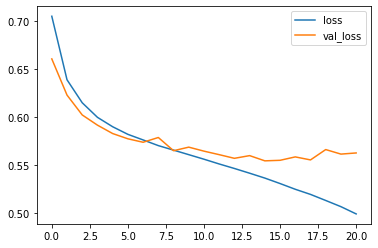

In [33]:
df_epoch_hist = pd.DataFrame(history.history)
df_epoch_hist[['loss','val_loss']].plot()

In [34]:
# depd = {'auc_1' : metrics.AUC}
model_load = load_model(PATH_MODEL + 'ws_data_model5_iter3.h5',compile=False)

In [35]:
model_load.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 15, 256)           264192    
_________________________________________________________________
lstm_9 (LSTM)                (None, 15, 128)           197120    
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [36]:
model_load.compile(loss='mean_squared_error', optimizer=opt, metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='the_rmse'),
        tf.keras.metrics.MeanAbsolutePercentageError(name='the_mape'),
    ])

In [37]:
model_load.evaluate(x_test,y_test)

3019/3019 [==============================] - 19s 6ms/step - loss: 0.5700 - the_rmse: 0.7550 - the_mape: 89684.8516


[0.5700282454490662, 0.7550021409988403, 89684.8515625]

In [38]:
model_load.evaluate(Xo,yo)

1250/1250 [==============================] - 9s 7ms/step - loss: 0.4470 - the_rmse: 0.6685 - the_mape: 88552.1406


[0.4469590187072754, 0.6685499548912048, 88552.140625]

: 